In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import visualkeras
import cv2
import os

np.random.seed(42)

# Data Load & Pre-prcessing

In [2]:
X_DATA_PATH = "./data/cropped/"
Y_DATA_PATH = "./data/preprocessed/images/"

x_data_path_list = os.listdir(X_DATA_PATH)[:32 * 50]
y_data_path_list = os.listdir(Y_DATA_PATH)

X, y = list(), list()
for x_data_path in tqdm(x_data_path_list, desc=f'X data loading...'):   X.append(cv2.imread(X_DATA_PATH + x_data_path))
for y_data_path in tqdm(y_data_path_list, desc=f'Y data loading...'):   y.append(cv2.imread(Y_DATA_PATH + y_data_path))

Y data loading...: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1235.04it/s]


In [3]:
y = np.array(y)[:, :, :, 0].reshape(-1, 256, 256, 1)
y = np.array(y) / 255.0

print(f"""Dataset shape : {y.shape}""")

Dataset shape : (2000, 256, 256, 1)


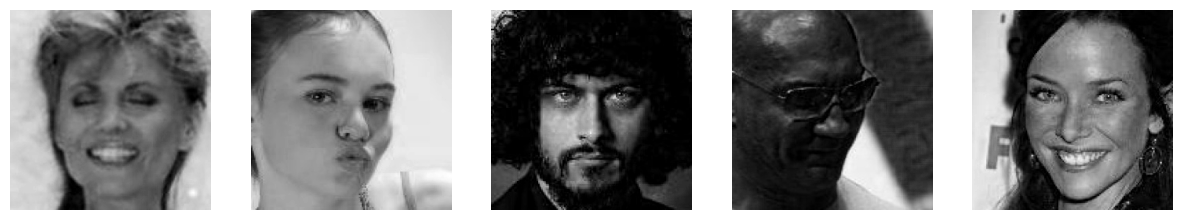

In [4]:
np.random.shuffle(y)
rand_idx = np.random.randint(0, len(y), 5)

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(rand_idx):
    ax[i].imshow(y[idx], cmap='gray')
    ax[i].axis('off')
plt.show()

# VAE Model

In [5]:
latent_space = 2

# ResNet BottleNeck Block
def BottleNeck(input_feature, in_channels, out_channels):
    x1 = Conv2D(in_channels, (1, 1), padding='same', activation='relu')(input_feature)
    x1 = layers.BatchNormalization()(x1)
    skip_connection = x1

    x1 = Conv2D(in_channels, (3, 3), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)

    x1 = Conv2D(out_channels, (1, 1), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)

    x1 = layers.add([x1, skip_connection])
    x1 = layers.Activation('relu')(x1)

    return x1

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon


In [6]:
# #ncoder
input_img = Input(shape=(256, 256, 1))

x1 = BottleNeck(input_img, 32, 32)

x2 = MaxPooling2D((2, 2), padding='same')(x1)
x2 = BottleNeck(x2, 64, 64)

x3 = MaxPooling2D((2, 2), padding='same')(x2)
x3 = BottleNeck(x3, 128, 128)

x3 = layers.Flatten()(x3)
z_mean = layers.Dense(latent_space, name="z_mean")(x3)
z_log_var = layers.Dense(latent_space, name="z_log_var")(x3)
z = Sampling()([z_mean, z_log_var])

encoder = Model(input_img, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  64          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

 z_log_var (Dense)              (None, 2)            1048578     ['flatten[0][0]']                
                                                                                                  
 sampling (Sampling)            (None, 2)            0           ['z_mean[0][0]',                 
                                                                  'z_log_var[0][0]']              
                                                                                                  
Total params: 2,325,828
Trainable params: 2,324,484
Non-trainable params: 1,344
__________________________________________________________________________________________________


In [7]:
# Decoder
latent_inputs = keras.Input(shape=(latent_space,), name="z_sampling")
x = layers.Dense(32 * 32 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 128))(x)

x1 = BottleNeck(x, 128, 128)
x2 = UpSampling2D((2, 2))(x1)

x2 = BottleNeck(x2, 64, 64)
x3 = UpSampling2D((2, 2))(x2)

x3 = BottleNeck(x3, 32, 32)
x3 = UpSampling2D((2, 2))(x3)

decoder_outputs = Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x3)
decoder_outputs = layers.Reshape((256, 256, 1))(decoder_outputs)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 z_sampling (InputLayer)        [(None, 2)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 131072)       393216      ['z_sampling[0][0]']             
                                                                                                  
 reshape (Reshape)              (None, 32, 32, 128)  0           ['dense[0][0]']                  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 128)  16512       ['reshape[0][0]']                
                                                                                            

                                                                                                  
 reshape_1 (Reshape)            (None, 256, 256, 1)  0           ['conv2d_transpose[0][0]']       
                                                                                                  
Total params: 638,529
Trainable params: 637,185
Non-trainable params: 1,344
__________________________________________________________________________________________________


In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005)
)

In [ ]:
vae.fit(
    y,
    epochs=10,
    batch_size=16,
)

Epoch 1/10
125/125 [==============================] - 21s 129ms/step - loss: 41409.7726 - reconstruction_loss: 39948.6641 - kl_loss: 89.0894
Epoch 2/10
125/125 [==============================] - 16s 129ms/step - loss: 38699.1286 - reconstruction_loss: 38664.1797 - kl_loss: 36.8528
Epoch 3/10
125/125 [==============================] - 16s 129ms/step - loss: 38504.6069 - reconstruction_loss: 38578.5273 - kl_loss: 23.1066
Epoch 4/10
125/125 [==============================] - 16s 129ms/step - loss: 38566.3581 - reconstruction_loss: 38465.0000 - kl_loss: 17.8153
Epoch 5/10
125/125 [==============================] - 16s 128ms/step - loss: 38523.9667 - reconstruction_loss: 38424.1328 - kl_loss: 16.8235
Epoch 6/10
125/125 [==============================] - 16s 128ms/step - loss: 38490.1980 - reconstruction_loss: 38401.5039 - kl_loss: 15.8394
Epoch 7/10
125/125 [==============================] - 16s 131ms/step - loss: 38177.7855 - reconstruction_loss: 38375.0664 - kl_loss: 15.0292
Epoch 8/10
12

In [ ]:
test_image = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (256, 256))
test_image = test_image.reshape(1, 256, 256, 1)
test_image = np.array(test_image) / 255.0

z_mean, z_log_var, z = encoder.predict(test_image)
reconstruction = decoder.predict(z)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_image.reshape(256, 256), cmap='gray')
ax[0].axis('off')
ax[1].imshow(reconstruction.reshape(256, 256), cmap='gray')
ax[1].axis('off')
plt.show()

print(z_mean, z_log_var, z)

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 256
    scale = 1.4
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)

In [ ]:
test_image = cv2.imread('./data/preprocessed/images/000033.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (256, 256))
test_image = test_image.reshape(1, 256, 256, 1)
test_image = np.array(test_image) / 255.0

z_mean, z_log_var, z = encoder.predict(test_image)
reconstruction = decoder.predict(z)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_image.reshape(256, 256), cmap='gray')
ax[0].axis('off')
ax[1].imshow(reconstruction.reshape(256, 256), cmap='gray')
ax[1].axis('off')
plt.show()

print(z_mean, z_log_var, z)

In [ ]:
test_image = cv2.imread('./data/preprocessed/images/000046.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (256, 256))
test_image = test_image.reshape(1, 256, 256, 1)
test_image = np.array(test_image) / 255.0

z_mean, z_log_var, z = encoder.predict(test_image)
reconstruction = decoder.predict(z)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_image.reshape(256, 256), cmap='gray')
ax[0].axis('off')
ax[1].imshow(reconstruction.reshape(256, 256), cmap='gray')
ax[1].axis('off')
plt.show()

print(z_mean, z_log_var, z)

In [ ]:
test_image = cv2.imread('./data/preprocessed/images/000037.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (256, 256))
test_image = test_image.reshape(1, 256, 256, 1)
test_image = np.array(test_image) / 255.0

z_mean, z_log_var, z = encoder.predict(test_image)
reconstruction = decoder.predict(z)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_image.reshape(256, 256), cmap='gray')
ax[0].axis('off')
ax[1].imshow(reconstruction.reshape(256, 256), cmap='gray')
ax[1].axis('off')
plt.show()

print(z_mean, z_log_var, z)

In [ ]:
test_image = cv2.imread('./data/preprocessed/images/000048.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (256, 256))
test_image = test_image.reshape(1, 256, 256, 1)
test_image = np.array(test_image) / 255.0

z_mean, z_log_var, z = encoder.predict(test_image)
reconstruction = decoder.predict(z)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_image.reshape(256, 256), cmap='gray')
ax[0].axis('off')
ax[1].imshow(reconstruction.reshape(256, 256), cmap='gray')
ax[1].axis('off')
plt.show()

print(z_mean, z_log_var, z)

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 256
    scale = 5
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)